# Preparation

## Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from sklearn.model_selection import GridSearchCV
import numpy as np

# scaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# models
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier 
from imblearn.ensemble import RUSBoostClassifier


# pipeline
from sklearn.pipeline import Pipeline 
from imblearn.pipeline import Pipeline as Pipeline_imb 

# resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour

# model selection
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# scoring
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import warnings
warnings.filterwarnings('ignore')

## Dataset

In [2]:
df = pd.read_csv("modified_insurance_fraud_detect_data.csv")

In [3]:
df_raw = df.copy()

In [4]:
df_raw.drop("Unnamed: 0", axis=1, inplace=True)

## Visualization

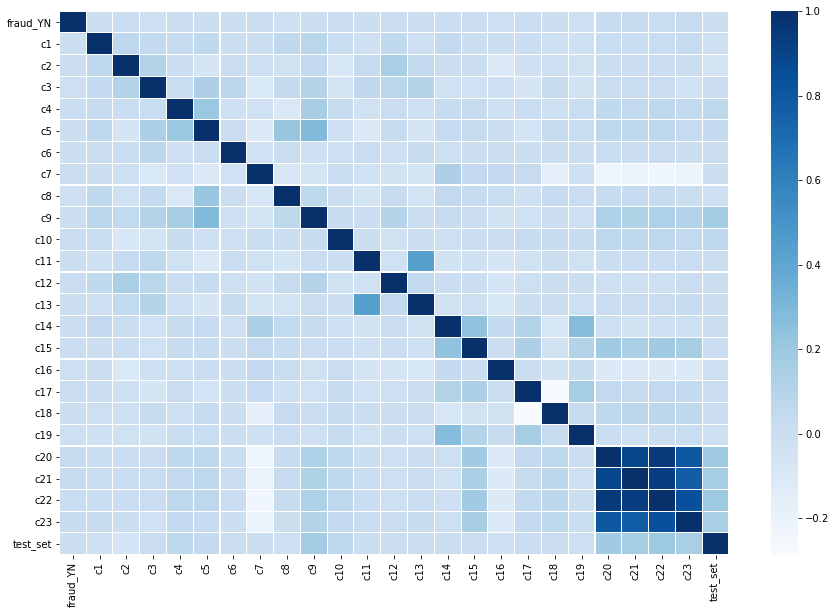

In [5]:
# correlation matrix
plt.figure(figsize = (15,10))
corr = df_raw.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Blues")
plt.show();

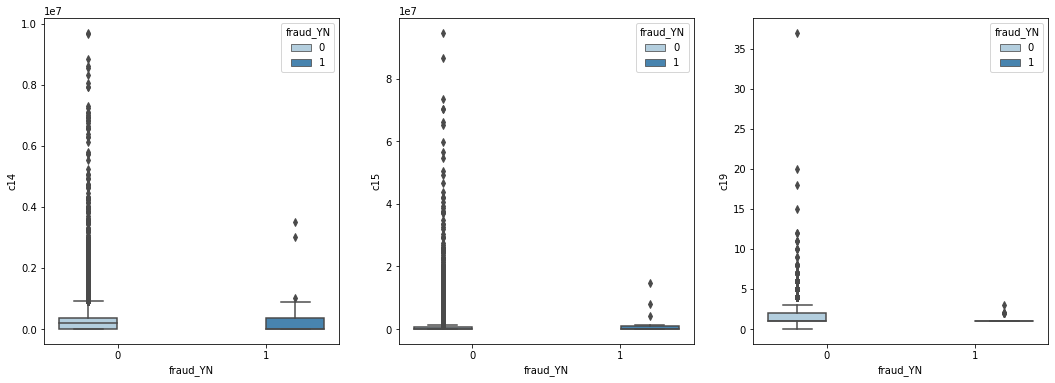

In [6]:
# repair_cost, insure_cost, repair_cnt
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6))
s = sns.boxplot(ax = ax1, x="fraud_YN", y="c14", hue="fraud_YN",data=df_raw, palette="Blues")
s = sns.boxplot(ax = ax2, x="fraud_YN", y="c15", hue="fraud_YN",data=df_raw, palette="Blues")
s = sns.boxplot(ax = ax3, x="fraud_YN", y="c19", hue="fraud_YN",data=df_raw, palette="Blues")
plt.show();

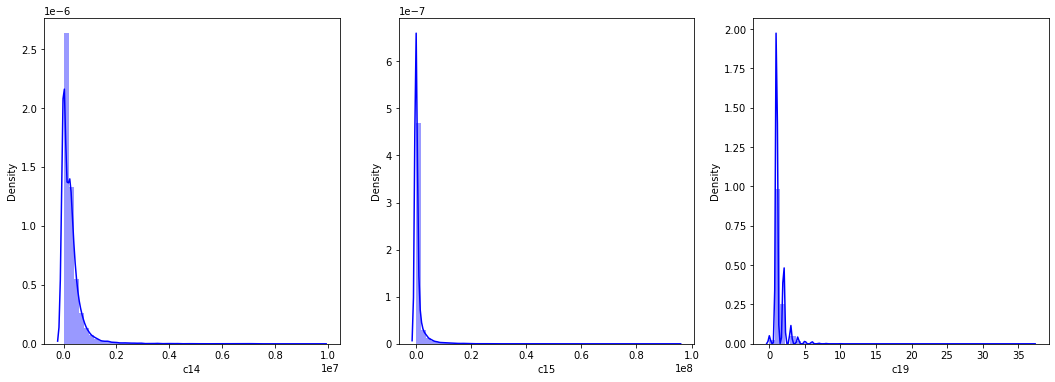

In [7]:
# repair_cost, insure_cost, repair_cnt
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6))
s = sns.distplot(ax = ax1, a = df_raw["c14"], color="b")
s = sns.distplot(ax = ax2, a = df_raw["c15"], color='b')
s = sns.distplot(ax = ax3, a = df_raw["c19"], color="b")
plt.show();

## One_Hot_Encoding

In [8]:
df_raw = pd.get_dummies(df_raw, columns=["c1", "c2", "c11", "c12", "c13",
                            "c16", "c20", "c21"])

## Train / Test 

In [9]:
X = df_raw.iloc[:, 1:]
y = df_raw.iloc[:, 0]

In [10]:
df_train = df_raw[df_raw["test_set"] == 0]
df_train = df_train.drop("test_set", axis=1)

df_test = df_raw[df_raw["test_set"] == 1]
df_test = df_test.drop("test_set", axis=1)

X_train = df_train.drop("fraud_YN", axis=1)
y_train = df_train["fraud_YN"]
X_test = df_test.drop("fraud_YN", axis=1)
y_test = df_test["fraud_YN"]

## Confusion Matrix

In [11]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score)

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    return acc, pre, re, f1

In [12]:
from sklearn.metrics import confusion_matrix

def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    acc, pre, re, f1 = get_clf_eval(y_test, pred)
    print("Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1: {3:.4f}".format(acc, pre, re, f1))

# Modeling

## Raw Data

### Baseline
- Logistic Regression
- Linear SVC
- Random Forest Classifier

In [13]:
models = []
models.append(('LogisticRegression', LogisticRegression(random_state=13)))
models.append(('SupportVectorMachine', LinearSVC(random_state=13)))
models.append(('RandomForest', RandomForestClassifier(random_state=13)))

train_accuracy = []
train_recall = []
train_precision = []
test_accuracy = []
test_recall = []
test_precision = []
names = []

for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    names.append(name)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    train_recall.append(recall_score(y_train, y_pred_train))
    train_precision.append(precision_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_recall.append(recall_score(y_test, y_pred_test))
    test_precision.append(precision_score(y_test, y_pred_test))


result = pd.DataFrame({'model name':names, 
                       'train accuracy':train_accuracy,
                       'train precision':train_precision,
                       'train recall':train_recall,
                       'test accuracy':test_accuracy,
                       'test precision':test_precision,
                       'test recall':test_recall}) 
result

,model name,train accuracy,train precision,train recall,test accuracy,test precision,test recall
0,LogisticRegression,0.99736,0.0,0.0,0.997757,0.0,0.0
1,SupportVectorMachine,0.99736,0.0,0.0,0.997757,0.0,0.0
2,RandomForest,1.00000,1.0,1.0,0.997757,0.0,0.0


### Pipeline (RobustScaler) -> GridSearch

In [14]:
# pipeline
lr_pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("clf", LogisticRegression(random_state=13))])

svm_pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("clf", LinearSVC(random_state=13))])

rf_pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("clf", RandomForestClassifier(random_state=13))])


# grid search params
lr_param_grid = [{'clf__penalty': ['l1', 'l2', 'elasticnet', 'none']}]

svm_param_grid = [{"clf__penalty": ["l1", "l2"],
                    "clf__loss": ["hinge", "squared_hinge"]}]

rf_param_grid = [{'clf__n_estimators': [1, 5, 10, 20],
                  'clf__max_depth' : [2, 3, 4, 5, 10, 50, 100]}]


# grid search CV
LR = GridSearchCV(lr_pipe, lr_param_grid, cv=5, scoring = 'recall')
SVM = GridSearchCV(svm_pipe, svm_param_grid, cv=5, scoring = 'recall')
RF = GridSearchCV(rf_pipe, rf_param_grid, cv=5, scoring = 'recall')

In [15]:
grids = []
grids.append(('LogisticRegression', LR))
grids.append(('SupportVectorMachine', SVM))
grids.append(('RandomForest', RF))

              
train_accuracy = []
train_recall = []
train_precision = []
test_accuracy = []
test_recall = []
test_precision = []
names = []
    
for name, grid in grids:
    clf = grid
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    names.append(name)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    train_recall.append(recall_score(y_train, y_pred_train))
    train_precision.append(precision_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_recall.append(recall_score(y_test, y_pred_test))
    test_precision.append(precision_score(y_test, y_pred_test))


result = pd.DataFrame({'model name':names, 
                       'train accuracy':train_accuracy,
                       'train precision':train_precision,
                       'train recall':train_recall,
                       'test accuracy':test_accuracy,
                       'test precision':test_precision,
                       'test recall':test_recall}) 
result

,model name,train accuracy,train precision,train recall,test accuracy,test precision,test recall
0,LogisticRegression,0.99736,0.0,0.0,0.997757,0.0,0.0
1,SupportVectorMachine,0.99736,0.0,0.0,0.997757,0.0,0.0
2,RandomForest,0.99736,0.0,0.0,0.997757,0.0,0.0


### Resampling

#### OverSampling

##### Random Over Sampler

In [16]:
over_sampling = RandomOverSampler(random_state=22)
X_train_over, y_train_over = over_sampling.fit_sample(X_train, y_train)

In [17]:
X_train.shape, y_train.shape

((12879, 53), (12879,))

In [18]:
X_train_over.shape, y_train_over.shape

((25690, 53), (25690,))

In [19]:
grids = []
grids.append(('LogisticRegression', LR))
grids.append(('SupportVectorMachine', SVM))
grids.append(('RandomForest', RF))
              
train_accuracy = []
train_recall = []
train_precision = []
test_accuracy = []
test_recall = []
test_precision = []
names = []
    
for name, grid in grids:
    clf = grid
    clf.fit(X_train_over, y_train_over)
    
    y_pred_train = clf.predict(X_train_over)
    y_pred_test = clf.predict(X_test)

    names.append(name)
    train_accuracy.append(accuracy_score(y_train_over, y_pred_train))
    train_recall.append(recall_score(y_train_over, y_pred_train))
    train_precision.append(precision_score(y_train_over, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_recall.append(recall_score(y_test, y_pred_test))
    test_precision.append(precision_score(y_test, y_pred_test))


result = pd.DataFrame({'model name':names, 
                       'train accuracy':train_accuracy,
                       'train precision':train_precision,
                       'train recall':train_recall,
                       'test accuracy':test_accuracy,
                       'test precision':test_precision,
                       'test recall':test_recall}) 
result

,model name,train accuracy,train precision,train recall,test accuracy,test precision,test recall
0,LogisticRegression,0.813546,0.787822,0.858233,0.685357,0.004069,0.571429
1,SupportVectorMachine,0.844492,0.788086,0.942390,0.679590,0.003003,0.428571
2,RandomForest,0.989763,0.979936,1.000000,0.967959,0.000000,0.000000


##### SMOTE

In [20]:
over_sampling = SMOTE()
X_train_over, y_train_over = over_sampling.fit_sample(X_train, y_train)

In [21]:
X_train.shape, y_train.shape

((12879, 53), (12879,))

In [22]:
X_train_over.shape, y_train_over.shape

((25690, 53), (25690,))

In [23]:
grids = []
grids.append(('LogisticRegression', LR))
grids.append(('SupportVectorMachine', SVM))
grids.append(('RandomForest', RF))
              
train_accuracy = []
train_recall = []
train_precision = []
test_accuracy = []
test_recall = []
test_precision = []
names = []
    
for name, grid in grids:
    clf = grid
    clf.fit(X_train_over, y_train_over)
    
    y_pred_train = clf.predict(X_train_over)
    y_pred_test = clf.predict(X_test)

    names.append(name)
    train_accuracy.append(accuracy_score(y_train_over, y_pred_train))
    train_recall.append(recall_score(y_train_over, y_pred_train))
    train_precision.append(precision_score(y_train_over, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_recall.append(recall_score(y_test, y_pred_test))
    test_precision.append(precision_score(y_test, y_pred_test))


result = pd.DataFrame({'model name':names, 
                       'train accuracy':train_accuracy,
                       'train precision':train_precision,
                       'train recall':train_recall,
                       'test accuracy':test_accuracy,
                       'test precision':test_precision,
                       'test recall':test_recall}) 
result

,model name,train accuracy,train precision,train recall,test accuracy,test precision,test recall
0,LogisticRegression,0.998599,0.999688,0.997509,0.997116,0.0,0.0
1,SupportVectorMachine,0.998404,0.999298,0.997509,0.997116,0.0,0.0
2,RandomForest,0.994589,0.990731,0.998521,0.987824,0.0,0.0


#### Undersampling

##### Random Under Sampler

In [24]:
under_sampling = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampling.fit_sample(X_train, y_train)

In [25]:
X_train.shape, y_train.shape

((12879, 53), (12879,))

In [26]:
X_train_under.shape, y_train_under.shape

((68, 53), (68,))

In [27]:
grids = []
grids.append(('LogisticRegression', LR))
grids.append(('SupportVectorMachine', SVM))
grids.append(('RandomForest', RF))
              
train_accuracy = []
train_recall = []
train_precision = []
test_accuracy = []
test_recall = []
test_precision = []
names = []
    
for name, grid in grids:
    clf = grid
    clf.fit(X_train_under, y_train_under)
    
    y_pred_train = clf.predict(X_train_under)
    y_pred_test = clf.predict(X_test)

    names.append(name)
    train_accuracy.append(accuracy_score(y_train_under, y_pred_train))
    train_recall.append(recall_score(y_train_under, y_pred_train))
    train_precision.append(precision_score(y_train_under, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_recall.append(recall_score(y_test, y_pred_test))
    test_precision.append(precision_score(y_test, y_pred_test))


result = pd.DataFrame({'model name':names, 
                       'train accuracy':train_accuracy,
                       'train precision':train_precision,
                       'train recall':train_recall,
                       'test accuracy':test_accuracy,
                       'test precision':test_precision,
                       'test recall':test_recall}) 
result

,model name,train accuracy,train precision,train recall,test accuracy,test precision,test recall
0,LogisticRegression,0.867647,0.878788,0.852941,0.522269,0.002681,0.571429
1,SupportVectorMachine,0.955882,0.969697,0.941176,0.567767,0.002963,0.571429
2,RandomForest,0.852941,0.852941,0.852941,0.492470,0.002524,0.571429


##### NearMiss

In [28]:
under_sampling = NearMiss(n_neighbors_ver3=3)
X_train_under, y_train_under = under_sampling.fit_sample(X_train, y_train)

In [29]:
X_train.shape, y_train.shape

((12879, 53), (12879,))

In [30]:
X_train_under.shape, y_train_under.shape

((68, 53), (68,))

In [31]:
grids = []
grids.append(('LogisticRegression', LR))
grids.append(('SupportVectorMachine', SVM))
grids.append(('RandomForest', RF))
              
train_accuracy = []
train_recall = []
train_precision = []
test_accuracy = []
test_recall = []
test_precision = []
names = []
    
for name, grid in grids:
    clf = grid
    clf.fit(X_train_under, y_train_under)
    
    y_pred_train = clf.predict(X_train_under)
    y_pred_test = clf.predict(X_test)

    names.append(name)
    train_accuracy.append(accuracy_score(y_train_under, y_pred_train))
    train_recall.append(recall_score(y_train_under, y_pred_train))
    train_precision.append(precision_score(y_train_under, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_recall.append(recall_score(y_test, y_pred_test))
    test_precision.append(precision_score(y_test, y_pred_test))


result = pd.DataFrame({'model name':names, 
                       'train accuracy':train_accuracy,
                       'train precision':train_precision,
                       'train recall':train_recall,
                       'test accuracy':test_accuracy,
                       'test precision':test_precision,
                       'test recall':test_recall}) 
result

,model name,train accuracy,train precision,train recall,test accuracy,test precision,test recall
0,LogisticRegression,1.000000,1.0,1.000000,0.201538,0.001604,0.571429
1,SupportVectorMachine,0.941176,1.0,0.882353,0.192887,0.001587,0.571429
2,RandomForest,0.926471,1.0,0.852941,0.238706,0.001683,0.571429


##### CondensedNearestNeighbour

In [32]:
under_sampling = CondensedNearestNeighbour(n_neighbors=3)
X_train_under, y_train_under = under_sampling.fit_sample(X_train, y_train)
X_train_under.shape, y_train_under.shape

((178, 53), (178,))

In [33]:
grids = []
grids.append(('LogisticRegression', LR))
grids.append(('SupportVectorMachine', SVM))
grids.append(('RandomForest', RF))
              
train_accuracy = []
train_recall = []
train_precision = []
test_accuracy = []
test_recall = []
test_precision = []
names = []
    
for name, grid in grids:
    clf = grid
    clf.fit(X_train_under, y_train_under)
    
    y_pred_train = clf.predict(X_train_under)
    y_pred_test = clf.predict(X_test)

    names.append(name)
    train_accuracy.append(accuracy_score(y_train_under, y_pred_train))
    train_recall.append(recall_score(y_train_under, y_pred_train))
    train_precision.append(precision_score(y_train_under, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_recall.append(recall_score(y_test, y_pred_test))
    test_precision.append(precision_score(y_test, y_pred_test))


result = pd.DataFrame({'model name':names, 
                       'train accuracy':train_accuracy,
                       'train precision':train_precision,
                       'train recall':train_recall,
                       'test accuracy':test_accuracy,
                       'test precision':test_precision,
                       'test recall':test_recall}) 
result

,model name,train accuracy,train precision,train recall,test accuracy,test precision,test recall
0,LogisticRegression,0.859551,0.680000,0.500000,0.829221,0.005639,0.428571
1,SupportVectorMachine,0.792135,0.434783,0.294118,0.790131,0.004587,0.428571
2,RandomForest,0.876404,0.700000,0.617647,0.810958,0.005093,0.428571


### Ensemble with resampling
- BalancedRandomForestClassifier -> RandomForest를 기반한 모델
- EasyEnsembleClassifier -> Adaboost를 기반한 모델
- RUSBoostClassifier -> Adaboost를 기반한 모델

In [34]:
# pipeline
brf_pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("clf", BalancedRandomForestClassifier(random_state=13))])

ee_pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("clf", EasyEnsembleClassifier(random_state=13))])

rusb_pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("clf",RUSBoostClassifier(random_state=13))])

# param grid
brf_param_grid= [{'clf__n_estimators': [2, 5, 10, 20, 50, 100],
    'clf__max_depth' : [5, 10, 50, 100]}]

ee_param_grid = [{'clf__n_estimators': [2, 5, 10, 20, 50, 100]}]

rusb_param_grid = [{'clf__n_estimators': [2, 5, 10, 20, 50, 100],
    'clf__learning_rate': [0.5, 1]}]

# gridsearch
BRF = GridSearchCV(brf_pipe, brf_param_grid, cv=5, scoring = 'recall')
EE = GridSearchCV(ee_pipe, ee_param_grid, cv=5, scoring = 'recall')
RUSB = GridSearchCV(rusb_pipe, rusb_param_grid, cv=5, scoring = 'recall')

grids = []
grids.append(('BalancedRandomForest', BRF))
grids.append(('EasyEnsemble', EE))
grids.append(('RUSBoost', RUSB))
              
train_accuracy = []
train_recall = []
train_precision = []
test_accuracy = []
test_recall = []
test_precision = []
names = []
    
for name, grid in grids:
    clf = grid
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    names.append(name)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    train_recall.append(recall_score(y_train, y_pred_train))
    train_precision.append(precision_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_recall.append(recall_score(y_test, y_pred_test))
    test_precision.append(precision_score(y_test, y_pred_test))


result = pd.DataFrame({'model name':names, 
                       'train accuracy':train_accuracy,
                       'train precision':train_precision,
                       'train recall':train_recall,
                       'test accuracy':test_accuracy,
                       'test precision':test_precision,
                       'test recall':test_recall}) 
result # recall focused

,model name,train accuracy,train precision,train recall,test accuracy,test precision,test recall
0,BalancedRandomForest,0.576054,0.005829,0.941176,0.470682,0.001817,0.428571
1,EasyEnsemble,0.677848,0.008128,1.000000,0.521948,0.002679,0.571429
2,RUSBoost,0.765976,0.009223,0.823529,0.696892,0.001063,0.142857


## 모델 검증

In [35]:
EE = GridSearchCV(ee_pipe, ee_param_grid, cv=5, scoring = 'recall')

In [36]:
# EasyEnsembleClassifier train

skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=13)
print("each accuracy : {}".format(cross_val_score(EE, X_train, y_train, cv=skfold, scoring="accuracy")))
print("each precision : {}".format(cross_val_score(EE, X_train, y_train, cv=skfold, scoring="precision")))
print("each recall : {}".format(cross_val_score(EE, X_train, y_train, cv=skfold, scoring="recall")))
print("average accuracy : {}".format(sum(cross_val_score(EE, X_train, y_train, cv=skfold, scoring="accuracy"))/3))
print("average precision : {}".format(sum(cross_val_score(EE, X_train, y_train, cv=skfold, scoring="precision"))/3))
print("average recall : {}".format(sum(cross_val_score(EE, X_train, y_train, cv=skfold, scoring="recall"))/3))

each accuracy : [0.55765199 0.5639413  0.55462381]
each precision : [0.00368034 0.00478978 0.00365726]
each recall : [0.63636364 0.81818182 0.58333333]
average accuracy : 0.5587390325335818
average precision : 0.004042460188229521
average recall : 0.6792929292929294


## 모델 선정

### EasyEnsembleClassifier

Accuracy: 0.5219, Precision: 0.0027, Recall: 0.5714, F1: 0.0053


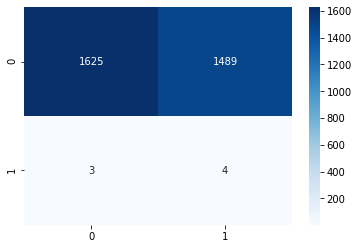

In [37]:
EE = GridSearchCV(ee_pipe, ee_param_grid, cv=5, scoring = 'recall')
EE.fit(X_train, y_train)
pred = EE.predict(X_test)
print_clf_eval(y_test, pred)

## Precision & Recall Trade-Off

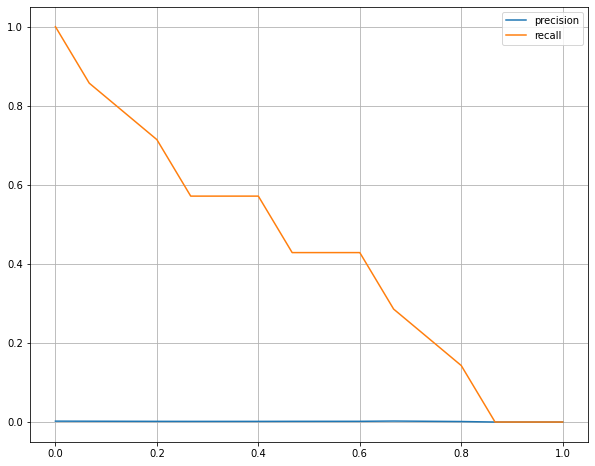

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

plt.figure(figsize=(10,8))
pred = BRF.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, pred)
plt.plot(thresholds, precisions[:len(thresholds)], label="precision")
plt.plot(thresholds, recalls[:len(thresholds)], label="recall")
plt.grid(); plt.legend(); plt.show()